In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import random

c:\Users\user\anaconda3\envs\MAIN_ENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
image_res = 256

image_center_x = 0
image_center_y = 0
zoom_factor = 1

init_center = 0
init_range = 1

token_length = 8
tokenizer_embedding_size = 768

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2 + token_length * tokenizer_embedding_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 3)
        
        nn.init.uniform_(self.fc1.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fc2.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fc3.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fc4.weight, a=-init_range, b=init_range)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid((self.fc4(x)))
        
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (fc1): Linear(in_features=6146, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
)

In [4]:
loss = nn.BCELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.00005)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def tokenize(text, fixed_length):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    
    if len(tokens) > fixed_length:
        tokens = tokens[:fixed_length]
    else:
        tokens += [0] * (fixed_length - len(tokens))

    tokens_tensor = torch.tensor([tokens])

    outputs = model.get_input_embeddings()(tokens_tensor)

    return outputs[0].flatten().detach()

In [6]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((image_res, image_res))
    img = img.convert("RGB")
    img_array = np.array(img) / 255

    return torch.tensor(img_array, dtype=torch.float32, device=GPU)

In [7]:
def display_image(img_array):
    img_array = np.array(img_array)
    plt.imshow(img_array)
    plt.show()

In [8]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    calc_loss = loss(outputs, answer_tensor)
    calc_loss.backward()
    optimizer.step()

In [9]:
def get_net_ip(text):
    tokenized = tokenize(text, token_length)
    
    coords = torch.meshgrid((torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 - image_center_y) * zoom_factor,
                            (torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 + image_center_x) * zoom_factor)
    
    coords = torch.stack(coords, dim=-1)
    
    with_tokens = torch.zeros(image_res, image_res, 2 + token_length * tokenizer_embedding_size, dtype=torch.float32, device=GPU)
    
    with_tokens[:, :, :token_length * tokenizer_embedding_size] = tokenized.repeat(image_res, image_res, 1)
    with_tokens[:, :, token_length * tokenizer_embedding_size:] = coords
    
    return with_tokens

In [10]:
def get_img_array(text):
    image = net(get_net_ip(text))
    return image

In [11]:
dir1 = r"C:\Users\user\Desktop\learning from human\images\squares"
dir2 = r"C:\Users\user\Desktop\learning from human\images\triangles"
dir3 = r"C:\Users\user\Desktop\learning from human\images\stars"
tok1 = ["green", "green square", "a green square", "square"]
tok2 = ["red", "red triangle", "a red triangle", "triangle"]
tok3 = ["yellow", "yellow star", "a yellow star", "star"]
files1 = os.listdir(dir1)
files2 = os.listdir(dir2)
files3 = os.listdir(dir3)

questions = []
answers = []

for x in tqdm(range(len(files1))):
    img1 = load_image(fr"{dir1}\{files1[x]}")
    img2 = load_image(fr"{dir2}\{files2[x]}")
    img3 = load_image(fr"{dir3}\{files3[x]}")
    
    answers.append(img1)
    answers.append(img2)
    answers.append(img3)
    
    questions.append(get_net_ip(tok1[random.randint(0, len(tok1) - 1)]))
    questions.append(get_net_ip(tok2[random.randint(0, len(tok2) - 1)]))
    questions.append(get_net_ip(tok3[random.randint(0, len(tok3) - 1)]))

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\MAIN_ENV\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 10/10 [00:00<00:00, 30.25it/s]


In [12]:
for y in tqdm(range(500)):
    for x in (range(len(questions))):
        train_nn(questions[x], answers[x], net)

100%|██████████| 500/500 [00:33<00:00, 14.98it/s]


i know its really bad (it doesnt know how to do anything outside of what it was trained on),
but this is an example of how you can generate images using text in this method.
this is also increased resolution examples


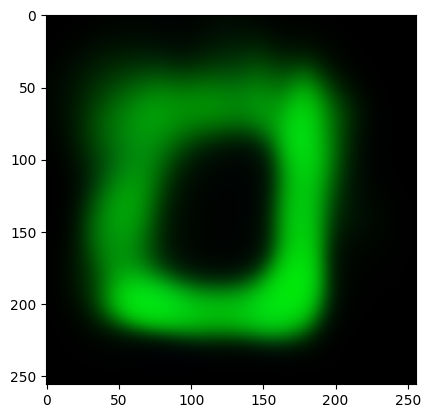

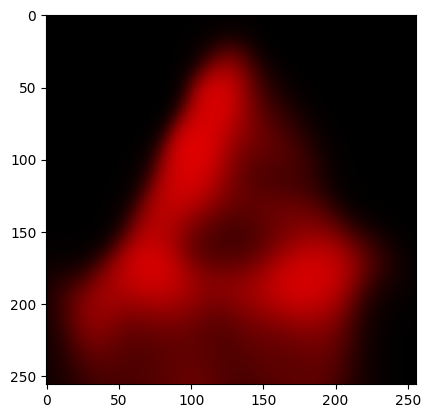

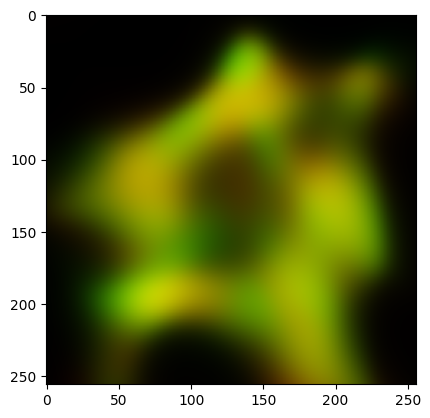

examples of the original images:


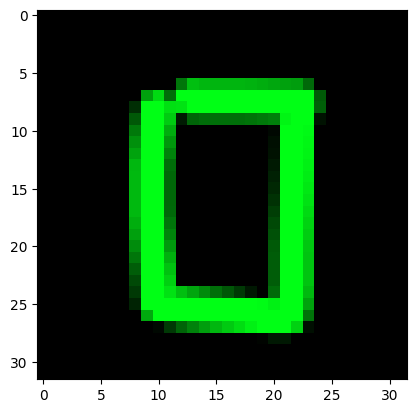

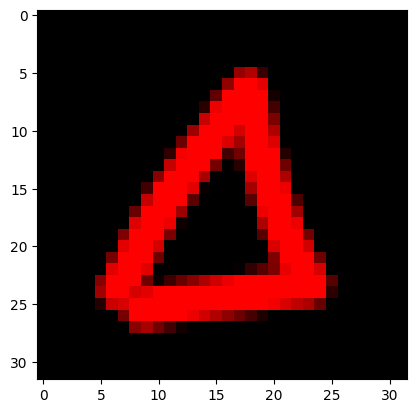

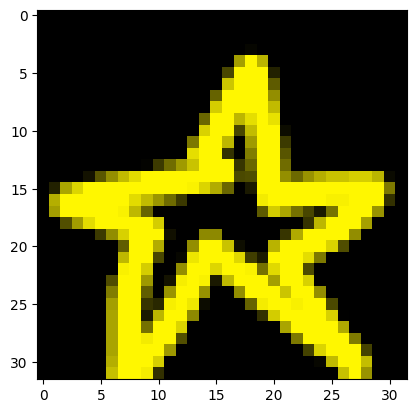

In [24]:
print("i know its really bad (it doesnt know how to do anything outside of what it was trained on),\nbut this is an example of how you can generate images using text in this method.\nthis is also increased resolution examples")
display_image(get_img_array("green square").detach().cpu())
display_image(get_img_array("triangle").detach().cpu())
display_image(get_img_array("yellow star").detach().cpu())
print("examples of the original images:")
display_image(answers[0].detach().cpu())
display_image(answers[1].detach().cpu())
display_image(answers[2].detach().cpu())